# Introduction aux API

Dans ce notebook, on va apprendre à :
- Consommer une API avec `requests`
- Transformer les données en DataFrame avec `pandas`
- Visualiser des statistiques avec `matplotlib`
- Créer sa propre API avec `FastAPI`

- Créer une application interactive avec `Streamlit`

In [35]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

### Exercice 1 : Récupération de données depuis l’API INSEE

Explorateur de données INSEE : https://catalogue-donnees.insee.fr/fr/explorateur/DS_EC_NAIS

URL de l'API : https://api.insee.fr/melodi/data/DS_EC_NAIS?FREQ=M&EC_MEASURE=LVB&GEO=DEP


**Objectif** :
1. Explorer les données INSEE pour vous familiariser avec
2. Faire une requête GET avec l'url directement
3. Faire une requête GET avec l'url et l'utilisation de paramètres
4. Comprendre le format JSON
5. Explorer les données reçues
    - afficher les clés du dictionnaire
    - afficher le nombre d'éléments contenu dans la key `observations`
    - afficher le label en francais et anglais que vous trouverez dans la key `publisher`

In [36]:
# 2. Faire une requête GET avec l'url directement
url = "https://api.insee.fr/melodi/data/DS_EC_NAIS?FREQ=M&EC_MEASURE=LVB&GEO=DEP"

response = requests.get(url, timeout=30)

if response.ok:
    data = response.json()
    print(data.keys())
else:
    print("Erreur :", response.status_code)

dict_keys(['identifier', 'title', 'publisher', 'observations', 'paging'])


In [7]:
# 3. Faire une requête GET avec l'url et l'utilisation de paramètres
url = "https://api.insee.fr/melodi/data/DS_EC_NAIS"
params = {
    "FREQ": "M",
    "EC_MEASURE": "LVB",
    "GEO": "DEP"
}

try:
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    data = response.json()
    print(data.keys())
except Exception as e:
    print("Erreur :", e)

dict_keys(['identifier', 'title', 'publisher', 'observations', 'paging'])


In [21]:
# 5. Explorer les données reçues
## afficher les clés du dictionnaire
print(data.keys())
## afficher le nombre d'éléments contenu dans la key `observations``
print(len(data.get("observations", [])))
## afficher le label en francais et anglais que vous trouverez dans la key `publisher`
labels = data.get("publisher", {}).get("label", [])
for label in labels:
    lang, content = label.values()
    print(lang, ":", content)

dict_keys(['identifier', 'title', 'publisher', 'observations', 'paging'])
1000
fr : Institut national de la statistique et des etudes economiques (INSEE)
en : National Institute of Statistics and Economic Studies


### Exercice 2 : Mise en forme des données avec Pandas

**Objectif** :
- Transformer le JSON en DataFrame
- Colonnes : **département, mois, naissances**
- Trier les données par département et mois
- Afficher les premières lignes du DataFrame

In [37]:
df = pd.DataFrame()

for obs in data.get("observations", []):
    dimensions: dict = obs.get("dimensions", {})
    dep: str = dimensions.get("GEO", "").split('-')[-1]
    month: str = dimensions.get("TIME_PERIOD")
    nb_births: float = obs.get("measures", {}).get(
        "OBS_VALUE_NIVEAU", {}).get("value")
    tmp_df = pd.DataFrame(
        [[dep, month, nb_births]],
        columns=["departement", "mois", "naissances"])
    df = pd.concat([df, tmp_df])
df.sort_values(by=["departement", "mois"], ascending=True,ignore_index=True, inplace=True)

df.head()

,departement,mois,naissances
0,01,2020-03,565.0
1,01,2020-11,547.0
2,01,2022-05,559.0
3,01,2023-05,522.0
4,01,2024-05,557.0


In [ ]:
from collections import defaultdict

records = defaultdict(list)
# equivalent à
# records = {
#     "departement": [],
#     "mois": [],
#     "naissances": []
# }

for obs in data.get("observations", []):
    dimensions: dict = obs.get("dimensions", {})
    records["departement"].append(dimensions.get("GEO", "").split('-')[-1])
    records["mois"].append(dimensions.get("TIME_PERIOD"))
    records["naissances"].append(obs.get("measures", {}).get(
        "OBS_VALUE_NIVEAU", {}).get("value"))

df = pd.DataFrame(records)
df.sort_values(by=["departement", "mois"], ascending=True, ignore_index=True, inplace=True)

df.head()

,departement,mois,naissances
0,01,2020-03,565.0
1,01,2020-11,547.0
2,01,2022-05,559.0
3,01,2023-05,522.0
4,01,2024-05,557.0


In [30]:
records = []

for obs in data.get("observations", []):
    dimensions: dict = obs.get("dimensions", {})
    dep: str = dimensions.get("GEO", "").split('-')[-1]
    month: str = dimensions.get("TIME_PERIOD")
    nb_births: float = obs.get("measures", {}).get("OBS_VALUE_NIVEAU", {}).get("value")
    records.append([dep, month, nb_births])

df = pd.DataFrame(records, columns=["departement", "mois", "naissances"])
df.sort_values(by=["departement", "mois"], ascending=True, ignore_index=True, inplace=True)

df.head()

,departement,mois,naissances
0,01,2020-03,565.0
1,01,2020-11,547.0
2,01,2022-05,559.0
3,01,2023-05,522.0
4,01,2024-05,557.0


### Exercice 3 : Visualisation des données

👉 Objectif :
- Visualiser l’évolution des naissances pour le département 75
- Comparer plusieurs départements ["75", "69", "33", "13"] avec un subplot

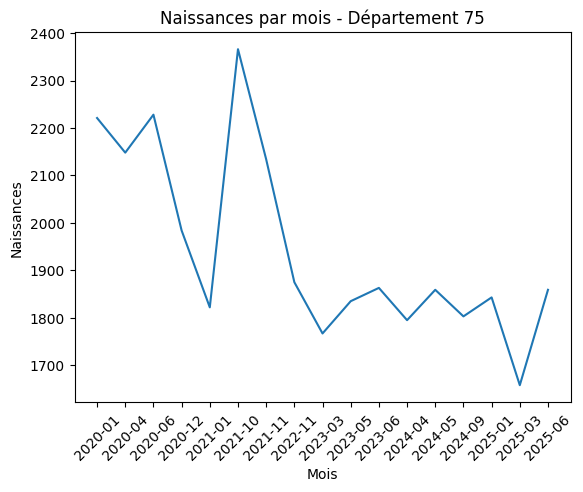

In [31]:
dep = "75"
df_dep = df[df["departement"] == dep]
df_dep = df.query("departement == '75'")

plt.plot(df_dep["mois"], df_dep["naissances"])
plt.xticks(rotation=45)
plt.title(f"Naissances par mois - Département {dep}")
plt.xlabel("Mois")
plt.ylabel("Naissances")
plt.show()

Créer un subplot 2x2 (2 lignes, 2 colonnes) qui affiche l'évolution des naissances pour les départements 75, 69, 33, 13.













/var/folders/2f/q6j_9jv52mxg0j621kjyv2s80000gn/T/ipykernel_15439/304889718.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_dep["mois"], rotation=45)


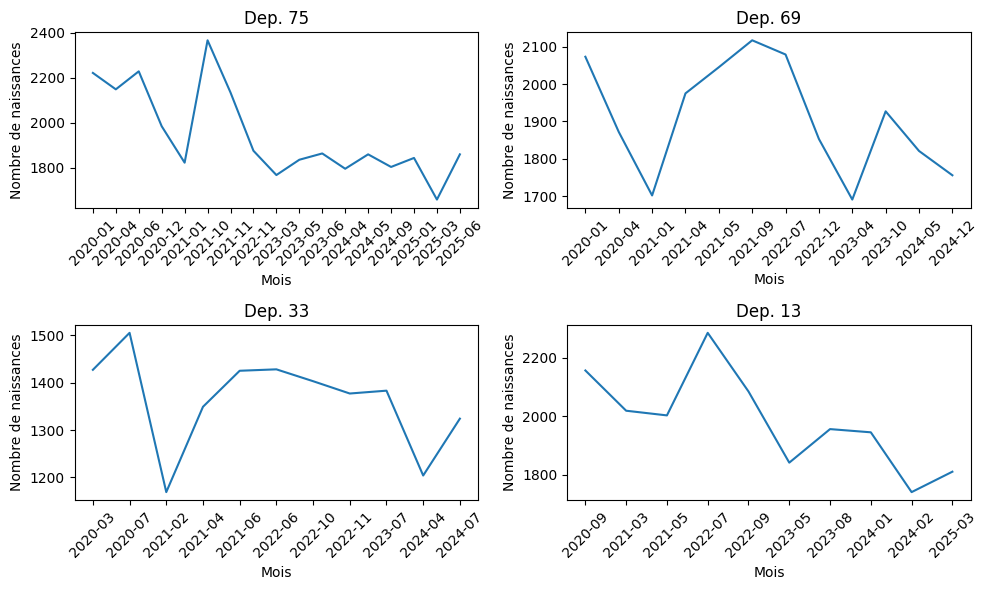

In [32]:
departments = ["75", "69", "33", "13"]

fig, axes = plt.subplots(int(len(departments)/2), 2, figsize=(10, 6))

axes = axes.ravel()

# iterate over each department
for i, dep in enumerate(departments):
    df_dep = df[df["departement"] == dep]
    axes[i].plot(df_dep["mois"], df_dep["naissances"], label=f"Dép. {dep}")
    axes[i].set_title(f"Dep. {dep}")
    axes[i].set_xlabel("Mois")
    axes[i].set_ylabel("Nombre de naissances")
    axes[i].set_xticklabels(df_dep["mois"], rotation=45)
    # axes[i].legend(False)

plt.tight_layout()
plt.show()